In [1]:
from os import listdir, path, mkdir
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime as dt
import requests
from tqdm import tqdm
import os
import glob
import pandas as pd
from wps_formatter import WRFInputFormatter

In [2]:
def get_file_by_url(url, file_name, overwrite=False):
    if path.exists(file_name) and not overwrite:
        return
    response = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(response.content)

In [3]:
def create_dir(path_to_dir):
    if path_to_dir == '':
        return
    if path.exists(path_to_dir):
        return
    else:
        mkdir(path_to_dir)

In [4]:
def clear_dir(path):
    files = glob.glob(f'{path}/*')
    for f in files:
        os.remove(f)

In [5]:
def download_reanalysis_year_spreads(year, local_path='data', verbose=False, overwrite=False):
    #define a bunch of constants refering to where these datasets are stored on the NOAA servers
    year_id = 'SI' if year < 1981 else 'MO'
    BASE_URL = 'https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3'
    SPREADS_URL = 'https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3/spreads'
    
    DATA_PATHS = [f'accums{year_id}/apcp.{year}.nc', f'sfc{year_id}/prate.{year}.nc', f'accums{year_id}/snod.{year}.nc',
                  f'subsfc{year_id}/soilw.{year}.nc', f'accums{year_id}/runoff.{year}.nc']
                  #f'prs{year_id}/hgt.{year}.nc', f'prs{year_id}/uwnd.{year}.nc', f'prs{year_id}/vwnd.{year}.nc']
    
    #download everything save the surface variables
    create_dir(f'{local_path}/{year}')
    create_dir(f'{local_path}/{year}/means')
    create_dir(f'{local_path}/{year}/spreads')
    for path_file in DATA_PATHS:
        if verbose:
                print(f'Downloading {path_file}')
        get_file_by_url(f'{BASE_URL}/{path_file}', f'{local_path}/{year}/means/{path_file.split("/")[1]}', overwrite=overwrite)
        get_file_by_url(f'{SPREADS_URL}/{path_file}', f'{local_path}/{year}/spreads/{path_file.split("/")[1]}', overwrite=overwrite)

In [6]:
def download_reanalysis_year(year, local_path='data', verbose=False, overwrite=False):
    #define a bunch of constants refering to where these datasets are stored on the NOAA servers
    year_id = 'SI' if year < 1981 else 'MO'
    DATA_SUBSETS = ['mean_sea_level', 'pressure_levels', 'subsurface', 'tropopause', 'two_meters', 'ten_meters']
    DATA_PATHS   = [f'misc{year_id}', f'prs{year_id}', f'subsfc{year_id}', f'tropo{year_id}', f'2m{year_id}', f'10m{year_id}']
    BASE_URL = 'https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3'
    #SPREADS_URL = 'https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3/spreads'

    MSL_FILES = [f'prmsl.{year}.nc']
    PL_FILES = [f'air.{year}.nc', f'hgt.{year}.nc', f'rhum.{year}.nc', f'uwnd.{year}.nc', f'vwnd.{year}.nc']
    SS_FILES = [f'soilw.{year}.nc', f'tsoil.{year}.nc']
    TP_FILES = [f'air.tropo.{year}.nc', f'hgt.tropo.{year}.nc', f'pres.tropo.{year}.nc', 
                f'uwnd.tropo.{year}.nc', f'vwnd.tropo.{year}.nc']
    TM_FILES = [f'air.2m.{year}.nc', f'rhum.2m.{year}.nc']
    TEN_FILES = [f'uwnd.10m.{year}.nc', f'vwnd.10m.{year}.nc']
    
    MASTER_FILE_LIST = [MSL_FILES, PL_FILES, SS_FILES, TP_FILES, TM_FILES, TEN_FILES]
    
    #unlike the others, the surface variables are in a couple of different repositories, so they are accessed differently
    SURFACE_PATHS = [f'timeInvariant{year_id}/land.nc', f'sfc{year_id}/pres.sfc.{year}.nc', 
                     f'sfc{year_id}/skt.{year}.nc', f'accums{year_id}/snod.{year}.nc', f'timeInvariant{year_id}/hgt.sfc.nc']
    
    #download everything save the surface variables
    create_dir(f'{local_path}/{year}')
    create_dir(f'{local_path}/{year}/means')
    create_dir(f'{local_path}/{year}/spreads')
    for directory, noaa_path, file_list in zip(DATA_SUBSETS, DATA_PATHS, MASTER_FILE_LIST):
        create_dir(f'{local_path}/{year}/means/{directory}')
        for file in file_list:
            if verbose:
                print(file)
            get_file_by_url(f'{BASE_URL}/{noaa_path}/{file}', f'{local_path}/{year}/means/{directory}/{file}', overwrite=overwrite)
                   
    
    #and now for the surface variables
    create_dir(f'{local_path}/{year}/means/surface')
    create_dir(f'{local_path}/{year}/spreads/surface')
    for path_file in SURFACE_PATHS:
        get_file_by_url(f'{BASE_URL}/{path_file}', f'{local_path}/{year}/means/surface/{path_file.split("/")[1]}', overwrite=overwrite)
                   
        
    #finally, we've got change the names/variables names of some files so the import program
    #can work with it
    update_list = {f'{local_path}/{year}/means/surface/hgt.sfc.nc': 'hgtsfc', 
                   f'{local_path}/{year}/means/surface/pres.sfc.{year}.nc': 'psfc',
                   f'{local_path}/{year}/means/ten_meters/uwnd.10m.{year}.nc': 'uas',
                   f'{local_path}/{year}/means/ten_meters/vwnd.10m.{year}.nc': 'vas',
                   f'{local_path}/{year}/means/tropopause/air.tropo.{year}.nc': 'airtrp',
                   f'{local_path}/{year}/means/tropopause/hgt.tropo.{year}.nc': 'hgttrp',
                   f'{local_path}/{year}/means/tropopause/pres.tropo.{year}.nc': 'prestrp',
                   f'{local_path}/{year}/means/tropopause/uwnd.tropo.{year}.nc': 'uwndtrp',
                   f'{local_path}/{year}/means/tropopause/vwnd.tropo.{year}.nc': 'vwndtrp',
                   f'{local_path}/{year}/means/two_meters/air.2m.{year}.nc': 'tas',
                   f'{local_path}/{year}/means/two_meters/rhum.2m.{year}.nc': 'rhums'
                  }
    for file in update_list:
        new_name = f'{file[:file.rfind("/")]}/{update_list[file]}.nc'
        old_var = file[file.rfind('/')+1:].split('.')[0]
        
        if path.exists(file):
            old_dataset = xr.open_dataset(file)
            new_dataset = old_dataset.rename({old_var: update_list[file]})
            new_dataset.to_netcdf(new_name)

            old_dataset.close()
            os.remove(file)

In [7]:
#right now it can't handle the tropopause and 2 meter datasets with the same variable name easily, need to fix
def generate_variable_list(data_path, year, grib_codes):
    variable_paths = {}
    for level_type in os.listdir(f'{data_path}/{year}/means'):
        if level_type == '.ipynb_checkpoints' or '.nc' in level_type:
            continue
        for variable_file in os.listdir(f'{data_path}/{year}/means/{level_type}'):
            if variable_file == '.ipynb_checkpoints':
                continue
            var_name = variable_file.split('.')[0]
            if var_name in variable_paths:
                continue
            variable_paths[var_name] = f'{data_path}/{year}/means/{level_type}/{variable_file}'
            if var_name not in grib_codes.index:
                print(f'{var_name} must be added to grib codes table')
    return variable_paths

In [8]:
def add_row_to_grib_codes(grib_codes_list, var_name, description, grib_code, 
                          level_code, metgrid_name, metgrid_units, 
                          save_path=None, overwrite=False):
    grib_codes_list.loc[var_name] = [description, grib_code, level_code, metgrid_name, metgrid_units]

In [14]:
grib_codes = pd.read_pickle('grib_codes.df.pkl')
add_row_to_grib_codes(grib_codes, 'prmsl', 'Pressure reduced to mean sea level', '2', '102', 'PMSL', 'Pa')
add_row_to_grib_codes(grib_codes, 'air', 'Air Temperature', '11', '', 'TT', 'K')
add_row_to_grib_codes(grib_codes, 'hgt', 'Geopotential Height', '7', '', 'HGT', 'm')
add_row_to_grib_codes(grib_codes, 'rhum', 'Relative Humidity', '52', '', 'RH', '%')
add_row_to_grib_codes(grib_codes, 'uwnd', 'U Wind', '33', '', 'UU', 'm s-1')
add_row_to_grib_codes(grib_codes, 'vwnd', 'V Wind', '34', '', 'VV', 'm s-1')
add_row_to_grib_codes(grib_codes, 'pres', 'Surface Pressure', '1', '1', 'PSFC', 'Pa')
add_row_to_grib_codes(grib_codes, 'skt', 'Skin Temperature', '11', '1', 'SKINTEMP', 'K')
add_row_to_grib_codes(grib_codes, 'snod', 'Snow Depth', '66', '1', 'SNOWH', 'm')
add_row_to_grib_codes(grib_codes, 'hgtsfc', 'Terrain Height', '7', '1', 'SOILHGT', 'm')
add_row_to_grib_codes(grib_codes, 'airtrp', 'Air Temperature at Tropopause', '2', '7', 'TTROP', 'K')
add_row_to_grib_codes(grib_codes, 'hgttrp', 'Geopotential Height at Tropopause', '7', '7', 'HGTTROP', 'm')
add_row_to_grib_codes(grib_codes, 'prestrp', 'Pressure at Tropopause', '2', '7', 'PTROP', 'Pa')
add_row_to_grib_codes(grib_codes, 'uwndtrp', 'U Wind at Tropopause', '2' , '7', 'UTROP', 'm s-1')
add_row_to_grib_codes(grib_codes, 'vwndtrp', 'V Wind at Tropopause', '2' , '7', 'VTROP', 'm s-1')
add_row_to_grib_codes(grib_codes, 'rhums', 'Relative Humidity at 2 Meters', '52' , '105', 'RH', '%')
add_row_to_grib_codes(grib_codes, 'land', 'Land/Sea Flag', '81', '1', 'LANDSEA', 'proprtn')

In [15]:
variable_paths = generate_variable_list('data', 1993, grib_codes)

params = {
    'variable_paths' : variable_paths,
    'variable_table' : grib_codes,
    
    # Subset to this time range (start, end)
    'time_range' : (dt.datetime(1993,3,21,0), dt.datetime(1993,3,22,12)),
    
    # We want output every this many hours.  This particular
    # string format is what xarray looks for
    'time_freq' : '3H',
    
    # Set the vertical coordinate type of the raw dataset.
    # Options are 'pressure', with limited support for 'hybrid-p' and 'hybrid-z'
    'vcoord_type' : 'pressure',
    
    # These are the names of the vertical coordinates in the datasets
    # For upper air pressure levels:
    'vcoord' : 'level',
    
    # And for subsurface soil levels
    'soilcoord' : 'level'
}

In [16]:
wrfgen = WRFInputFormatter(**params)

2022-12-16 08:26:32,662 - WRFInputFormatter - INFO - THESE ARE GEOG BOUNDS: None
2022-12-16 08:26:32,663 - WRFInputFormatter - INFO - Building domain structure from pressure field
2022-12-16 08:26:32,664 - WRFInputFormatter - INFO - Loading and subsetting air
2022-12-16 08:26:32,665 - WRFInputFormatter - INFO - Loading variable air from: data/1993/means/pressure_levels/air.1993.nc
2022-12-16 08:26:33,638 - WRFInputFormatter - INFO - Data already at requested frequency of 3H
2022-12-16 08:26:34,164 - WRFInputFormatter - WARNING - Suspect we have hPa...converting to Pa
2022-12-16 08:26:34,882 - WRFInputFormatter - INFO - Done with pressure
2022-12-16 08:26:34,883 - WRFInputFormatter - INFO - GEOG BOUNDS REQD: None
2022-12-16 08:26:34,883 - WRFInputFormatter - INFO - ACTUAL LATS: -90.0 -- 90.0
2022-12-16 08:26:34,884 - WRFInputFormatter - INFO - ACTUAL LONS: 0.0 -- 359.0
2022-12-16 08:26:34,886 - WRFInputFormatter - INFO - Done with initialization


In [17]:
wrfgen.open_WPS_files(outpath = '/home/bparazin/WRF/WPS-4.4')

In [18]:
temp = None
temp2 = None
rhum_input = None
for var in list(variable_paths.keys()):
    # Load and subset this variable based on 
    # our spatial and temporal dimensions
    # Returns an xarray.DataArray, so this can
    # be looked at and plotted
    varray = wrfgen.load_and_subset(var)
    
    
    if var in ['air', 'hgt', 'uwnd', 'vwnd']:
        varray = varray[:,:21]
    
    # Soil variables need
    # additional processing
    if var in ['tsoil','soilw']:
        varray = wrfgen.process_soil_levels(varray) 
        temp = varray
        
    if var == 'rhum':
        rhum_input = varray
        
    #landmask is broken, this fixes it
    if var == 'land':
        varray = np.floor((~np.isnan(temp).any(axis=1).data + varray) / 2)
        temp2 = varray
        continue
        
    #if var != 'land':
    #    continue
    
    #if np.isnan(varray).any():
    #    print(var)
    wrfgen.add_to_WPS(varray)

2022-12-16 08:26:35,697 - WRFInputFormatter - INFO - Loading and subsetting prmsl
2022-12-16 08:26:35,699 - WRFInputFormatter - INFO - Loading variable prmsl from: data/1993/means/mean_sea_level/prmsl.1993.nc
2022-12-16 08:26:36,679 - WRFInputFormatter - INFO - Data already at requested frequency of 3H
2022-12-16 08:26:36,680 - WRFInputFormatter - INFO - Writing prmsl to WPS files
2022-12-16 08:26:36,684 - WRFInputFormatter - INFO -    1993-03-21 00:00:00
2022-12-16 08:26:36,706 - WRFInputFormatter - INFO -    1993-03-21 03:00:00
2022-12-16 08:26:36,724 - WRFInputFormatter - INFO -    1993-03-21 06:00:00
2022-12-16 08:26:36,743 - WRFInputFormatter - INFO -    1993-03-21 09:00:00
2022-12-16 08:26:36,760 - WRFInputFormatter - INFO -    1993-03-21 12:00:00
2022-12-16 08:26:36,778 - WRFInputFormatter - INFO -    1993-03-21 15:00:00
2022-12-16 08:26:36,801 - WRFInputFormatter - INFO -    1993-03-21 18:00:00
2022-12-16 08:26:36,824 - WRFInputFormatter - INFO -    1993-03-21 21:00:00
2022-12-

In [19]:
wrfgen.close_WPS_files()

In [24]:
rhum_in_slice = rhum_input.sel(lat=slice(20, 55), lon=slice(-120+360, -65+360))

In [27]:
np.max(rhum_in_slice)

<xarray.DataArray 'rhum' ()>
array(100., dtype=float32)

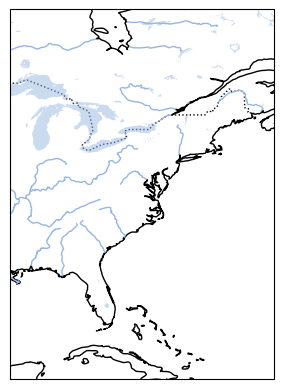

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-65, -90, 20, 55], crs=ccrs.PlateCarree())
#im = ax.pcolor(lon, lat, pert_geo)
#plt.colorbar(im)

In [17]:
check = xr.open_dataset('data/1993/means/pressure_levels/rhum.1993.nc')


In [ ]:
check.close()

In [ ]:
np.min(check['rhum'])

In [ ]:
nc

In [ ]:
for data, mask in zip(temp.data.flatten(), temp2.data.flatten()):
    if np.isnan(data) and mask != 0:
        print(mask)

In [9]:
ncg = xr.open_dataset('/home/bparazin/WRF/WPS-4.4/geo_em.d01.nc')
ncm = xr.open_dataset('/home/bparazin/WRF/WPS-4.4/met_em.d01.1993-03-21_21:00:00.nc')
ncw = xr.open_dataset('/home/bparazin/WRF/WRFV4.4.1/test/em_real/wrfinput_d01')

In [12]:
ncw

<xarray.Dataset>
Dimensions:               (Time: 1, south_north: 99, west_east: 99,
                           bottom_top: 44, bottom_top_stag: 45,
                           soil_layers_stag: 4, dust_erosion_dimension: 3,
                           west_east_stag: 100, south_north_stag: 100,
                           DIM0010: 5, land_cat_stag: 21, soil_cat_stag: 16,
                           num_ext_model_couple_dom_stag: 1)
Coordinates:
    XLAT                  (Time, south_north, west_east) float32 ...
    XLONG                 (Time, south_north, west_east) float32 ...
    XLAT_U                (Time, south_north, west_east_stag) float32 ...
    XLONG_U               (Time, south_north, west_east_stag) float32 ...
    XLAT_V                (Time, south_north_stag, west_east) float32 ...
    XLONG_V               (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                dust_erosion_dimension, west_east_stag,
                                south_north_stag, DIM0010, land_cat_stag,
                                soil_cat_stag, num_ext_model_couple_dom_stag
Data variables: (12/186)
    Times                 (Time) |S19 ...
    LU_INDEX              (Time, south_north, west_east) float32 ...
    ZNU                   (Time, bottom_top) float32 ...
    ZNW                   (Time, bottom_top_stag) float32 ...
    ZS                    (Time, soil_layers_stag) float32 ...
    DZS                   (Time, soil_layers_stag) float32 ...
    ...                    ...
    C4F                   (Time, bottom_top_stag) float32 ...
    PCB                   (Time, south_north, west_east) float32 ...
    PC                    (Time, south_north, west_east) float32 ...
    LANDMASK              (Time, south_north, west_east) float32 ...
    LAKEMASK              (Time, south_north, west_east) float32 ...
    SST                   (Time, south_north, west_east) float32 ...
Attributes: (12/90)
    TITLE:                            OUTPUT FROM REAL_EM V4.4.1 PREPROCESSOR
    START_DATE:                      1993-03-21_00:00:00
    SIMULATION_START_DATE:           1993-03-21_00:00:00
    WEST-EAST_GRID_DIMENSION:        100
    SOUTH-NORTH_GRID_DIMENSION:      100
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [ ]:
np.min(ncw['PB'].data), np.max(ncw['PB'].data)

In [ ]:
np.nanmin(ncw['P'].data), np.nanmax(ncw['P'].data)

In [ ]:
np.min(ncm['PTROP'].data), np.max(ncm['PTROP'].data)

In [10]:
for var in ncm:
    if var != 'Times':
        print(var, np.min(ncm[var].data),', ', np.max(ncm[var].data))

PRES 100.0 ,  102114.945
SOIL_LAYERS 10.0 ,  200.0
SM 0.100999996 ,  1.0
ST 265.81635 ,  299.16638
VTROP -33.263134 ,  -3.6485837
UTROP 1.0083857 ,  39.39711
PTROP 12487.102 ,  23379.55
HGTTROP 10376.958 ,  15090.86
TTROP 202.5277 ,  213.90839
SNOWH 0.0 ,  1.73
SKINTEMP 260.56387 ,  311.63373
PSFC 71141.57 ,  102114.945
SOILHGT 7.7096014 ,  3020.7534
ST100200 267.7896 ,  294.0896
ST040100 266.9658 ,  294.41577
ST010040 265.9694 ,  295.6694
ST000010 265.81635 ,  299.16638
SM100200 0.100999996 ,  1.0
SM040100 0.11049999 ,  1.0
SM010040 0.15953371 ,  1.0
SM000010 0.1438024 ,  1.0
VV -35.89553 ,  13.570677
UU -12.0726595 ,  41.853867
RH -6.248022 ,  105.51842
GHT 7.7096014 ,  16339.505
TT 204.66599 ,  303.55746
PMSL 100692.56 ,  103082.07
LANDSEA 0.0 ,  1.0
BATHYMETRY -265.17883 ,  3555.5837
SANDFRAC 0.0 ,  0.84999996
CLAYFRAC 0.0 ,  0.57
EROD 0.0 ,  0.037025
CANFRA 0.0 ,  93.91209
IMPERV 0.0 ,  46.884304
FRC_URB2D 0.0 ,  0.61356544
URB_PARAM 0.0 ,  11.766
LAKE_DEPTH 0.10119225 ,  289.2692

In [ ]:
for data, mask in zip(ncm['ST010040'].data.flatten(), ncm['LANDSEA'].data.flatten()):
    if mask==0:
        print(data)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-65, -130, 20, 55], crs=ccrs.PlateCarree())
lon = ncw['XLONG'].data[0]
lat = ncw['XLAT'].data[0]
mask = ncw['LANDMASK'].data[0]
im = ax.pcolor(lon, lat, mask)
#plt.colorbar(im)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-65, -130, 20, 55], crs=ccrs.PlateCarree())
lon = ncw['XLONG'].data[0]
lat = ncw['XLAT'].data[0]
st = ncw['SH2O'].data[0, 3]
im = ax.pcolor(lon, lat, st)
plt.colorbar(im)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-65, -130, 20, 55], crs=ccrs.PlateCarree())
lon = ncm['CLONG'].data[0]
lat = ncm['CLAT'].data[0]
mask = ncm['LANDSEA'].data[0]
im = ax.pcolor(lon, lat, mask)
#plt.colorbar(im)

In [ ]:
ncm['ST010040'].data[0, 1,0], ncm['XLONG_V'].data[0, 1,0], ncm['XLAT_V'].data[0, 1,0], ncm['LANDMASK'].data[0,1,0]

In [ ]:
nc['ST010040'].data[0, 1,0], nc['CLONG'].data[0, 1,0], nc['CLAT'].data[0, 1,0]

In [ ]:
np.bitwise_and(, temp2)

In [ ]:
np.shape(temp2)

In [ ]:
np.shape(temp)

In [ ]:
temp2.sel(lat=slice(17,20), lon=slice(-107+360, -104+360))

In [ ]:
temp3.sel(lat=slice(19,20), lon=slice(-105+360, -104+360), time=dt.datetime(1993, 3, 21))

In [ ]:
temp3 = xr.open_dataset('data/1993/means/subsurface/tsoil.1993.nc')

In [ ]:
np.isnan(temp3).any()